In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.16.1
Keras version: 3.12.0


In [2]:
# Load dataset
data = np.load('dataset_dev_3000.npz')
X = data['X']
y = data['y']

print(f"Input X shape: {X.shape}")
print(f"Targets y shape: {y.shape}")
print(f"Target A (10-class): range [{y[:, 0].min():.0f}, {y[:, 0].max():.0f}]")
print(f"Target B (32-class): {len(np.unique(y[:, 1]))} classes")
print(f"Target C (Regression): range [{y[:, 2].min():.4f}, {y[:, 2].max():.4f}]")

Input X shape: (3000, 32, 32)
Targets y shape: (3000, 3)
Target A (10-class): range [0, 9]
Target B (32-class): 32 classes
Target C (Regression): range [0.0003, 0.9996]


In [3]:
def phase_entropy(img):
    F = np.fft.fftshift(np.fft.fft2(img))
    phase = np.angle(F)
    hist, _ = np.histogram(phase, bins=32, range=(-np.pi, np.pi), density=True)
    hist += 1e-8
    return -np.sum(hist * np.log(hist))

pe = np.array([phase_entropy(im) for im in X])

from scipy.stats import spearmanr
print(spearmanr(pe, y[:,2]))

z_max = X.reshape(len(X), -1).max(axis=1)
from scipy.stats import spearmanr
print(spearmanr(z_max, y[:,2]))

def dominant_freq_radius(img):
    F = np.fft.fftshift(np.fft.fft2(img))
    P = np.abs(F)

    h, w = P.shape
    cy, cx = h//2, w//2
    y, x = np.indices((h, w))
    r = np.sqrt((x-cx)**2 + (y-cy)**2)

    # ignore DC
    P[cy, cx] = 0

    return r[np.unravel_index(np.argmax(P), P.shape)]

dom_r = np.array([dominant_freq_radius(im) for im in X])

from scipy.stats import spearmanr
print("Dominant freq vs A:", spearmanr(dom_r, y[:,2]))

import numpy as np
from scipy.stats import spearmanr

def spectral_bandwidth(img):
    F = np.fft.fftshift(np.fft.fft2(img))
    P = np.abs(F)**2

    h, w = P.shape
    cy, cx = h//2, w//2
    y, x = np.indices((h, w))
    r = np.sqrt((x-cx)**2 + (y-cy)**2)

    return np.sum(r**2 * P) / np.sum(P)

bw = np.array([spectral_bandwidth(im) for im in X])

print("Bandwidth vs C:", spearmanr(bw, y[:,2]))
from scipy.stats import pearsonr
print("Bandwidth (Pearson) vs C:", pearsonr(bw, y[:, 2]))


SignificanceResult(statistic=0.056643086803218445, pvalue=0.0019113730906978085)
SignificanceResult(statistic=-0.05393162003434903, pvalue=0.0031279477051970647)
Dominant freq vs A: SignificanceResult(statistic=-0.010890591931383838, pvalue=0.5509939488878911)
Bandwidth vs C: SignificanceResult(statistic=-0.09132385592487287, pvalue=5.431657047260366e-07)
Bandwidth (Pearson) vs C: PearsonRResult(statistic=-0.0666715054837064, pvalue=0.0002578914270064151)


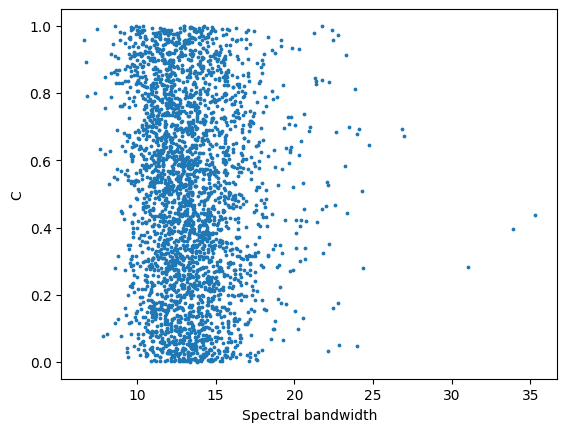

In [4]:
import matplotlib.pyplot as plt
plt.scatter(bw, y[:,2], s=3)
plt.xlabel("Spectral bandwidth")
plt.ylabel("C")
plt.show()


In [5]:
import numpy as np

import numpy as np

def vertical_asymmetry_batch(X):
    # X: (N, 32, 32, 1)
    upper = np.sum(X[:, :16, :, :], axis=(1, 2, 3))
    lower = np.sum(X[:, 16:, :, :], axis=(1, 2, 3))
    return ((upper - lower) / (upper + lower + 1e-6))[:, None]

def horizontal_asymmetry_batch(X):
    left = np.sum(X[:, :, :16, :], axis=(1, 2, 3))
    right = np.sum(X[:, :, 16:, :], axis=(1, 2, 3))
    return ((left - right) / (left + right + 1e-6))[:, None]

def com_x_batch(X):
    # X: (N, 32, 32, 1)
    xs = np.arange(32)[None, None, :, None]  # broadcast along x
    mass = np.sum(X, axis=(1,2,3)) + 1e-6
    com_x = np.sum(X * xs, axis=(1,2,3)) / mass
    return com_x[:, None]  # shape (N,1)


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# ============================================================
# 1. Inputs
# ============================================================
X_img = X[..., None].astype("float32")  # (N, 32, 32, 1)

# Targets
y_A = y[:, 0].astype("int32")  # 10-class
y_B = y[:, 1].astype("int32")  # 32-class
y_C = y[:, 2].astype("float32")  # regression

# ============================================================
# 2. Random train / validation split (shared indices)
# ============================================================
(
    X_train,
    X_val,
    y_A_train,
    y_A_val,
    y_B_train,
    y_B_val,
    y_C_train,
    y_C_val,
) = train_test_split(X_img, y_A, y_B, y_C, test_size=0.2, random_state=42, shuffle=True)

# ============================================================
# 3. Dataset-level normalization (important)
# ============================================================
mean = X_train.mean()
std = X_train.std() + 1e-6

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

targets = {
    "A": {
        "train": y_A_train,
        "val": y_A_val,
        "loss": "sparse_categorical_crossentropy",
        "metrics": ["accuracy"],
        "output_units": 10,
        "activation": "softmax",
    },
    "B": {
        "train": y_B_train,
        "val": y_B_val,
        "loss": "sparse_categorical_crossentropy",
        "metrics": ["accuracy"],
        "output_units": 32,
        "activation": "softmax",
    },
    "C": {
        "train": y_C_train,
        "val": y_C_val,
        "loss": "mse",
        "metrics": ["mae"],
        "output_units": 1,
        "activation": "sigmoid",
    },
}



## Compile Model

In [7]:
def get_augmentation_layer(augmentation_type):
    if augmentation_type is None:
        return None
    elif augmentation_type == "geometric":
        return keras.Sequential(
            [
                layers.RandomRotation(0.1),  # ±36° rotation
                layers.RandomZoom(0.1),  # ±10% zoom
                layers.RandomTranslation(0.1, 0.1),  # ±10% shift
            ],
            name="geometric_augmentation",
        )
    elif augmentation_type == "noise":
        return keras.Sequential(
            [
                layers.GaussianNoise(0.05),  # Add slight noise
            ],
            name="noise_augmentation",
        )
    else:
        raise ValueError(f"Unknown augmentation type: {augmentation_type}")


def build_cnn_model(
    input_shape,
    num_classes,
    augmentation_type=None,
    learning_rate=0.001,
    label_smoothing=0.0,
):
    inputs = layers.Input(shape=input_shape)

    # Apply data augmentation if specified
    augmentation_layer = get_augmentation_layer(augmentation_type)
    if augmentation_layer is not None:
        x = augmentation_layer(inputs)
    else:
        x = inputs

    # First Convolutional Block
    x = layers.Conv2D(32, (3, 3), padding="valid")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Second Convolutional Block
    x = layers.Conv2D(64, (3, 3), padding="valid")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Third Convolutional Block
    x = layers.Conv2D(128, (3, 3), padding="valid")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Choose loss function based on label smoothing
    # Label smoothing requires CategoricalCrossentropy with one-hot labels
    if label_smoothing > 0:
        loss = keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)
        use_onehot = True
    else:
        loss = "sparse_categorical_crossentropy"
        use_onehot = False

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=["accuracy"],
    )

    return model, use_onehot


# Define input shape
INPUT_SHAPE = X_train.shape[1:]  # (32, 32, 1)

print("Model Builder Configuration:")
print(f"  Input shape: {INPUT_SHAPE}")
print(f"  Target A classes: 10")
print(f"  Target B classes: 32")

Model Builder Configuration:
  Input shape: (32, 32, 1)
  Target A classes: 10
  Target B classes: 32


In [8]:
from tensorflow.keras import layers, models

from tensorflow.keras import layers, models


def build_simple_cnn_head_a():
    img_input = layers.Input(shape=(32, 32, 1), name="img")

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(img_input)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)

    # asym_input = layers.Input(shape=(1,), name="asym")

    # x = layers.Concatenate()([x, asym_input])
    # x = layers.Dense(32, activation="relu")(x)
    # x = layers.Dropout(0.5)(x)

    output = layers.Dense(10, activation="softmax")(x)

    model = models.Model(
        inputs=[img_input], outputs=output, name="cnn_head_a_with_asym"
    )

    return model



In [ ]:
from tensorflow.keras import layers, models


def build_cnn_regressor():
    inputs = tf.keras.Input(shape=(32, 32, 1), name="img")

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu", name="latent")(x)

    outputs = layers.Dense(1, name="C")(x)

    return tf.keras.Model(inputs, outputs)

def build_B_only_model():
    inputs = tf.keras.Input(shape=(32, 32, 1), name="img")

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)   # 16×16

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)   # 8×8

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(32, activation="softmax")(x)

    model = tf.keras.Model(inputs, output)
    model.compile(
        optimizer=Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [ ]:
TARGET = "C"  # Change to "A" or "B" to test different targets
cfg = targets[TARGET]

# Build the CNN model using build_cnn_model function
# model, use_onehot = build_cnn_model(
#     input_shape=INPUT_SHAPE,
#     num_classes=cfg["output_units"],
#     augmentation_type=None,        # or "geometric", "noise"
#     learning_rate=0.001,
#     label_smoothing=0.0            # or try 0.1 for label smoothing
# )

# If using label smoothing, we need one-hot encoded labels
# if use_onehot:
#     y_train_target = keras.utils.to_categorical(cfg["train"], cfg["output_units"])
#     y_val_target = keras.utils.to_categorical(cfg["val"], cfg["output_units"])
# else:
#     y_train_target = cfg["train"]
#     y_val_target = cfg["val"]

model, outputs = build_cnn_regressor()

print(f"\nTraining model for Target {TARGET}")
print(f"Model architecture:")
model.summary()

history = model.fit(
    X_train,
    y_train_target,
    validation_data=(X_val, y_val_target),
    epochs=30,
    batch_size=32,
    verbose=2
)


Training model for Target A
Model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,474 (400.29 KB)

 Trainable params: 102,026 (398.54 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
75/75 - 3s - 37ms/step - accuracy: 0.1771 - loss: 2.2428 - val_accuracy: 0.1217 - val_loss: 2.2380
Epoch 2/30
75/75 - 1s - 12ms/step - accuracy: 0.2571 - loss: 2.0448 - val_accuracy: 0.1050 - val_loss: 2.3736
Epoch 3/30
75/75 - 1s - 12ms/step - accuracy: 0.2758 - loss: 1.9589 - val_accuracy: 0.1317 - val_loss: 2.4873
Epoch 4/30
75/75 - 1s - 11ms/step - accuracy: 0.3142 - loss: 1.8763 - val_accuracy: 0.1050 - val_loss: 3.1351
Epoch 5/30
75/75 - 1s - 12ms/step - accuracy: 0.3308 - loss: 1.8067 - val_accuracy: 0.1133 - val_loss: 3.0918
Epoch 6/30
75/75 - 1s - 13ms/step - accuracy: 0.3579 - loss: 1.7519 - val_accuracy: 0.1050 - val_loss: 3.7158
Epoch 7/30
75/75 - 1s - 12ms/step - accuracy: 0.3779 - loss: 1.6999 - val_accuracy: 0.1183 - val_loss: 3.5905
Epoch 8/30
75/75 - 1s - 13ms/step - accuracy: 0.3900 - loss: 1.6468 - val_accuracy: 0.1033 - val_loss: 4.4169
Epoch 9/30
75/75 - 1s - 12ms/step - accuracy: 0.4442 - loss: 1.5575 - val_accuracy: 0.1550 - val_loss: 4.6473
Epoch 10/3

In [11]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

cfg = {
    "A": {
        "name": "HEAD A (10-class)",
        "y_val": y_A_val,
        "num_classes": 10,
        "task": "classification",
        "random_baseline": 1 / 10,
    },
    "B": {
        "name": "HEAD B (32-class)",
        "y_val": y_B_val,
        "num_classes": 32,
        "task": "classification",
        "random_baseline": 1 / 32,
    },
    "C": {
        "name": "HEAD C (regression)",
        "y_val": y_C_val,
        "task": "regression",
    },
}[TARGET]

print(f"\nFINAL VALIDATION RESULTS - {cfg['name']}")
print("=" * 60)

# ============================================================
# Evaluate loss + metric from Keras
# ============================================================
val_results = model.evaluate(X_val, cfg["y_val"], verbose=0)

if cfg["task"] == "classification":
    val_loss, val_metric = val_results
    print(f"Validation Loss     : {val_loss:.4f}")
    print(f"Validation Accuracy : {val_metric:.4f} ({val_metric*100:.2f}%)")
    print(
        f"Random baseline     : {cfg['random_baseline']:.4f} ({cfg['random_baseline']*100:.2f}%)"
    )

elif cfg["task"] == "regression":
    val_loss, val_mae = val_results
    print(f"Validation Loss (MSE): {val_loss:.4f}")
    print(f"Validation MAE      : {val_mae:.4f}")

# ============================================================
# Predictions
# ============================================================
predictions = model.predict(X_val, verbose=0)

if cfg["task"] == "classification":
    pred_classes = np.argmax(predictions, axis=1)

    accuracy = np.mean(pred_classes == cfg["y_val"])
    mae_classes = np.mean(np.abs(pred_classes - cfg["y_val"]))

    print(f"Explicit Accuracy   : {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Mean |class error|  : {mae_classes:.3f}")

elif cfg["task"] == "regression":
    preds = predictions.squeeze()

    mae = mean_absolute_error(cfg["y_val"], preds)
    r2 = r2_score(cfg["y_val"], preds)

    print(f"Explicit MAE        : {mae:.4f}")
    print(f"R² score            : {r2:.4f}")

print("=" * 60)


FINAL VALIDATION RESULTS - HEAD A (10-class)
Validation Loss     : 12.5499
Validation Accuracy : 0.1283 (12.83%)
Random baseline     : 0.1000 (10.00%)
Explicit Accuracy   : 0.1283 (12.83%)
Mean |class error|  : 3.048


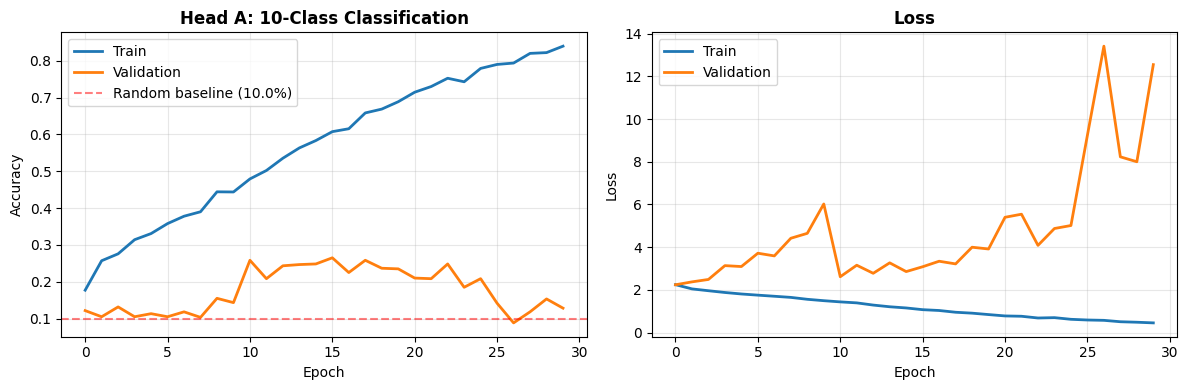

Training and validation plots displayed for Target A


In [12]:
import matplotlib.pyplot as plt

plot_cfg = {
    "A": {
        "task": "classification",
        "metric": "accuracy",
        "val_metric": "val_accuracy",
        "baseline": 1 / 10,
        "title": "Head A: 10-Class Classification",
        "ylabel": "Accuracy",
    },
    "B": {
        "task": "classification",
        "metric": "accuracy",
        "val_metric": "val_accuracy",
        "baseline": 1 / 32,
        "title": "Head B: 32-Class Classification",
        "ylabel": "Accuracy",
    },
    "C": {
        "task": "regression",
        "metric": "mae",
        "val_metric": "val_mae",
        "baseline": None,
        "title": "Head C: Regression",
        "ylabel": "MAE",
    },
}[TARGET]

# ============================================================
# Plot
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ---- Metric plot ----
axes[0].plot(history.history[plot_cfg["metric"]], label="Train", linewidth=2)
axes[0].plot(history.history[plot_cfg["val_metric"]], label="Validation", linewidth=2)

if plot_cfg["baseline"] is not None:
    axes[0].axhline(
        y=plot_cfg["baseline"],
        color="r",
        linestyle="--",
        alpha=0.5,
        label=f"Random baseline ({plot_cfg['baseline']*100:.1f}%)",
    )

axes[0].set_title(plot_cfg["title"], fontsize=12, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel(plot_cfg["ylabel"])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ---- Loss plot ----
axes[1].plot(history.history["loss"], label="Train", linewidth=2)
axes[1].plot(history.history["val_loss"], label="Validation", linewidth=2)
axes[1].set_title("Loss", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Training and validation plots displayed for Target {TARGET}")

In [13]:
# feature_extractor = tf.keras.Model(
#     inputs=model.input,
#     outputs=model.get_layer("latent").output
# )

# feature_extractor.trainable = False

# Z_train = feature_extractor.predict(X_train)
# Z_val   = feature_extractor.predict(X_val)

